In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, shutil

from general import *
from generation_stm import *
from storage_stm import *
from system_stm import *
from loaddata import calculate_greenhouse_load
from one_D_model import *

from radial_thermocline import radial_thermocline
from estimate_thermocline import estimate_thermocline
from create_simulation_history import create_simulation_history

from datetime import datetime, timedelta
import matplotlib.dates as mdates

In [2]:
# get load data
current_dir = os.getcwd()
original_weather_file = "C:\\Users\\johns\\OneDrive\\Desktop\\Sandia Mic'maq\\presque_isle_main_tmy.csv"

num_copies = 1
Kfiles = []
# creating multiple copies of the original weather file
for i in range(num_copies):
    new_file = os.path.join(current_dir, f'presque_isle_main_tmy_{i}.csv')
    shutil.copyfile(original_weather_file, new_file)
    Kfiles.append(new_file)
weather_files = Kfiles
greenhouse_load = calculate_greenhouse_load(weather_files)
ambient_temps = greenhouse_load['T_amb']
T_greenhouse = greenhouse_load['T_greenhouse']
greenhouse_load = greenhouse_load[['NetLoad_MW']]
ambient_temps = ambient_temps[1]
greenhouse_load_arr = greenhouse_load.to_numpy()
greenhouse_load_arr = greenhouse_load_arr.flatten()
date_range = pd.date_range(start='2033-01-01 00:30:00', periods=len(greenhouse_load_arr), freq='h')
greenhouse_load = pd.DataFrame({'load_MW': greenhouse_load_arr}, index=date_range)
greenhouse_load.index.name = 'Date/time'

ambient_temps = pd.DataFrame(ambient_temps, index=greenhouse_load.index, columns=['T_amb'])
ambient_temps.index.name = 'Date/time'

Total Q_net for the year: -287.74 MWh


c:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\loaddata.py:98: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2023-01-01', periods=num_hours, freq=f'{timestep_hours}H')
C:\Users\johns\AppData\Local\Temp\ipykernel_15900\1893184354.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ambient_temps = ambient_temps[1]


In [3]:

# TEA system setup

ratio_MW2acres = {'SAT': 0.24, 'fixed': 0.35}
pv_type = 'fixed'
pv_dc2ac = 1.2 
POI_limit = None  
analysis_period = 25  
ITC = 0.3  

# Setup Site and Systems
NSTTF_site = Site('NSTTF', Weather_Data(Kfiles), -7, POI_limit=POI_limit)
power_block = 0.2 # MW
PV_capacity_AC = 0.1 
PV_capacity_DC = PV_capacity_AC * pv_dc2ac  
ASGARD_PV = PV_System(
    name='ASGARD_PV',
    site=NSTTF_site,
    capacity_MW_DC=PV_capacity_DC,
    PV_array_type=pv_type,
    PV_tilt=30,
    PV_azimuth=180,
    ratio_DC2AC=pv_dc2ac,
    off_grid_operation=False,
    power_priority_load_MW_AC=None
)

TES_capacity_e = 1.1 # MWh
resistive_charge_rate = PV_capacity_DC 

ASGARD_TES = TES_System_STM(
    name='ASGARD_TES',
    site=NSTTF_site,
    capacity_MWh_t=TES_capacity_e / 0.98,
    power_rating_MW_e=power_block,
    power_minimum_MW_e=0,
    efficiency_rating_t2e=0.98,
    percent_discharge_depth=100,
    percent_heat_loss_daily=1,
    charge_rate_CSP_MW_t=0,
    charge_efficiency_t2TES=1,
    charge_rate_resistive_MW_e=resistive_charge_rate,
    charge_efficiency_e2TES=0.98,
    systems_charging=['ASGARD_PV'],
    start_full=False,
    off_grid_operation=True,
    DOE_2030_targets=False
)

systems = [ASGARD_PV, ASGARD_TES]
NSTTF = System(
    load_MW=greenhouse_load,
    systems_load_order=systems,
    analysis_period=analysis_period,
    ITC=ITC
)
tea_timeseries = NSTTF.timeseries

c:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\system_stm.py:483: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09483041435734925' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,'fuel_to_load_MWh_th'] = unmet_load_MW
c:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\system_stm.py:298: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0010174585077886119' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,pv.name+'_to_load_MWh_e'] = pv2l
c:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\system_stm.py:398: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0010174585077886119' has dtype incompatible with int64, please explicitly cast to a compatible dt

In [26]:
# ---------------------------
# 3. Process TEA Output for Thermocline

def calculate_net_tes_flow(timeseries, charge_col, discharge_col):
    return timeseries[charge_col].values - timeseries[discharge_col].values

charge_col = 'ASGARD_PV_to_ASGARD_TES_MWh_e'
discharge_col = 'ASGARD_TES_to_load_MWh_e'

# spring
single_day = '2033-03-20'  
next_day = '2033-03-22'
tea_day_spring = tea_timeseries.loc[single_day:next_day]
ambient_temp_spring = ambient_temps.loc[single_day:next_day].values + 273.15
single_day = '2023-03-20'  
next_day = '2023-03-22'
temperature_greenhouse_spring_C = T_greenhouse.loc[single_day:next_day].values
temperature_greenhouse_spring_K = temperature_greenhouse_spring_C + 273.15
net_TES_flow_MW_day_spring =  calculate_net_tes_flow(tea_day_spring, charge_col, discharge_col)


net_TES_flow_MW_day = net_TES_flow_MW_day_spring[11:23]
ambient_temp = ambient_temp_spring.flatten()[11:23]
temperature_greenhouse = temperature_greenhouse_spring_K[11:23]
print(len(net_TES_flow_MW_day),len(ambient_temp),len(temperature_greenhouse))

# net_TES_flow_MW_day = net_TES_flow_MW_day_spring[11:14]
# ambient_temp = ambient_temp_spring.flatten()[11:14]
# temperature_greenhouse = temperature_greenhouse_spring_K[11:14]
# print(len(net_TES_flow_MW_day),len(ambient_temp),len(temperature_greenhouse))

12 12 12


In [ ]:
# ---------------------------
# 4. Geometry and Thermocline Initialization

### model inputs 
# Simulation geometry
rL = 0.2286
rR = 1.02
B = 0.51
n = 20 # 65
################

GEOM_type = 'Radial'
HTF_type = 'air'
alpha = 0.9       
Dp = 0.009525     
eps = 0.4         
alpha_gravel = 3.0E-7   
h_surf_upper = 1.66
h_surf_lower = 0.1
h_surf_outer = 4.0
h_surf_inner = 0.02

# Air properties
cp_air = 1005.0  

if GEOM_type[0] == 'A':
    A_avg = 1
elif GEOM_type[0] == 'R':
    A_left = 2 * np.pi * rL * B
    A_right = 2 * np.pi * rR * B
    A_avg = (A_left + A_right) / 2
elif GEOM_type[0] == 'S':
    A_left = 4 * np.pi * rL**2
    A_right = 4 * np.pi * rR**2
    A_avg = (A_left + A_right) / 2


# Get mass flow rates 
chargeTemp = 550+273.15  # K 
mass_flow_rates = []
for hr, power_MW in enumerate(net_TES_flow_MW_day):
    power_W = power_MW * 1e6  # Convert MW to W
    # Determine delta T based on charging or discharging
    if power_MW > 0:  # Charging logic
        deltaT = chargeTemp - ambient_temp[hr]
    else:  # Discharging logic
        deltaT = chargeTemp - temperature_greenhouse[hr]
     
    if abs(deltaT) < 1e-3:
        mdot = 0
    else:
        mdot = power_W / (cp_air * deltaT)  # Calculate mass flow rate
    
    mass_flow_rates.append(mdot)

mass_flow_rates = np.array(mass_flow_rates)
print(f'net_TES_flow_MW_day, mass_flow_rates: {net_TES_flow_MW_day, mass_flow_rates}')

# simulation history matrix for 24 hourly phases
simPhases = []
for hr in range(len(mass_flow_rates)):
    M_dot = mass_flow_rates[hr]
    duration = 1  # 1 hour
    inletTemp = chargeTemp if M_dot > 0 else ambient_temp[hr]
    T_ref = ambient_temp[hr]
    simPhases.append([M_dot, duration, inletTemp, T_ref])
simHist = np.array(simPhases)
simHist

net_TES_flow_MW_day, mass_flow_rates: (array([ 0.1       ,  0.1       ,  0.1       ,  0.08943328,  0.05573171,
       -0.00802903, -0.06594797, -0.07484175, -0.07924418, -0.08098952,
       -0.08286332, -0.08473711]), array([ 0.18035615,  0.18048701,  0.18055251,  0.16144473,  0.1005338 ,
       -0.01536362, -0.12619205, -0.14321038, -0.15163449, -0.15497421,
       -0.15855973, -0.16214525]))


array([[ 1.80356149e-01,  1.00000000e+00,  8.23150000e+02,
         2.71450000e+02],
       [ 1.80487008e-01,  1.00000000e+00,  8.23150000e+02,
         2.71850000e+02],
       [ 1.80552509e-01,  1.00000000e+00,  8.23150000e+02,
         2.72050000e+02],
       [ 1.61444734e-01,  1.00000000e+00,  8.23150000e+02,
         2.71950000e+02],
       [ 1.00533796e-01,  1.00000000e+00,  8.23150000e+02,
         2.71550000e+02],
       [-1.53636166e-02,  1.00000000e+00,  2.70550000e+02,
         2.70550000e+02],
       [-1.26192053e-01,  1.00000000e+00,  2.68850000e+02,
         2.68850000e+02],
       [-1.43210384e-01,  1.00000000e+00,  2.67850000e+02,
         2.67850000e+02],
       [-1.51634486e-01,  1.00000000e+00,  2.65450000e+02,
         2.65450000e+02],
       [-1.54974210e-01,  1.00000000e+00,  2.64250000e+02,
         2.64250000e+02],
       [-1.58559732e-01,  1.00000000e+00,  2.63350000e+02,
         2.63350000e+02],
       [-1.62145253e-01,  1.00000000e+00,  2.62450000e+02,
      

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trace_radii = np.linspace(rL, rR, 12)

# Color mapping
charge_colors = {1: 'r', 0: 'g', -1: 'b'}

# Initial conditions
initial_phase = simHist[0]
M_dot_initial = initial_phase[0]
duration_initial = initial_phase[1] * 3600  
T_g0 = initial_phase[2]
T_s0 = ambient_temp[0] 
T_ref = T_s0
Tavg = (T_g0 + T_s0) / 2

estThermoclineLength, estSuperficialVelocity, estThermoclineVelocity = estimate_thermocline(
    M_dot_initial, A_avg, eps, alpha, Dp, Tavg, HTF_type)

if estThermoclineLength <= 0 or not np.isfinite(estThermoclineLength):
    estThermoclineLength = 0.1
if estSuperficialVelocity <= 0 or not np.isfinite(estSuperficialVelocity):
    estSuperficialVelocity = 0.01

dr = estThermoclineLength / n 
if dr <= 0:
    dr = 1e-3

LengthDomain = rR - rL
NSegs = max(int(np.floor(LengthDomain / dr)), 1)
NPoints = NSegs + 1

dt = 0.09 * (dr / estSuperficialVelocity)

T_initial = float(T_s0)
Tg = np.full(NPoints, T_initial, dtype=np.float64)
Ts = np.full(NPoints, T_initial, dtype=np.float64)
Tg[0] = float(T_g0)
Ts[0] = float(T_g0)

r = np.linspace(rL, rR, NPoints, dtype=np.float64)

# Get trace indices
NodesToTraceInTime = [np.abs(r - radius).argmin() for radius in trace_radii]

# History storage
sim_data = []
timeHistory = np.zeros((1, 1 + 2 * len(NodesToTraceInTime)))
phase_change_times = []

phaseStartTime = 0

# --- Main simulation loop ---
for iPhase, phase in enumerate(simHist):
    M_dot = phase[0]
    duration_sec = phase[1] * 3600
    T_g0 = phase[2]
    T_ref = phase[3]

    numSteps = int(np.floor(duration_sec / dt))
    if numSteps <= 0:
        continue

    charge_state = 1 if M_dot > 0 else 0 if M_dot == 0 else -1
    line_color = charge_colors[charge_state]

    Ts, Tg, timeHistory, phaseEndTime, energy_in, stored_energy, pumping_energy, dp_avg = radial_thermocline(
        Ts, Tg, HTF_type, r, numSteps, alpha, Dp, eps, B, alpha_gravel,
        h_surf_upper, h_surf_lower, h_surf_outer, h_surf_inner,
        M_dot, phaseStartTime, dt, T_g0, T_ref,
        NodesToTraceInTime, TraceTimeIncrement=5*60, timeHistory=timeHistory
    )

    df_phase = pd.DataFrame({
        'Phase': iPhase,
        'SimTime_sec': phaseEndTime,
        'Radius_m': r,
        'Temperature_C': Ts - 273.15,
        'Line_Color': line_color
    })
    sim_data.append(df_phase)

    phaseStartTime = phaseEndTime
    phase_change_times.append(phaseEndTime)

sim_data = pd.concat(sim_data, ignore_index=True)
timeHistory = timeHistory[:np.max(np.where(timeHistory[:, 0] > 0)[0]) + 1]  # Trim excess zero rows

Mdot: 0.180356149287999
v_s: 0.2523189075944987
Step 0/1005595: t = 0.0s, M_dot = 0.1804
Step 100000/1005595: t = 358.0s, M_dot = 0.1804


KeyboardInterrupt: 

In [ ]:
out_dir = r"C:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\geometries sims"
os.makedirs(out_dir, exist_ok=True)

# 1) Thermocline profiles
if isinstance(sim_data, list):
    sim_df = pd.concat(sim_data, ignore_index=True)
else:
    sim_df = sim_data.copy()

profiles_path = os.path.join(out_dir, "thermocline_profiles_1:2.csv")
sim_df.to_csv(profiles_path, index=False)
print(f"Wrote profiles to {profiles_path}")

# 2) Time history
numNodes = len(NodesToTraceInTime)
cols = ["time_sec"]
for j in range(numNodes):
    cols += [f"Tg_r{j}", f"Ts_r{j}"]

time_df = pd.DataFrame(timeHistory, columns=cols)
history_path = os.path.join(out_dir, "thermocline_timehistory_1:2.csv")
time_df.to_csv(history_path, index=False)
print(f"Wrote time history to {history_path}")

# 3) Geometry summary
ratio_str = f"1:{(rR/B):.2f}"

summary = pd.DataFrame([{
    "Ratio"          : ratio_str,
    "AvgDeltaP_Pa"   : dp_avg,
    "Pump_kWh"       : pumping_energy / 3.6e6,
    "Stored_MJ"      : stored_energy  / 1e6,
    "Insulation_m"   : thickness_super_wool
}])
summary_path = os.path.join(out_dir, "geometry_summary_1:2.csv")
summary.to_csv(summary_path, index=False)
print(f"Wrote summary to {summary_path}")


Wrote profiles to C:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\geometries sims\thermocline_profiles.csv
Wrote time history to C:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\geometries sims\thermocline_timehistory.csv
Wrote summary to C:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\geometries sims\geometry_summary.csv


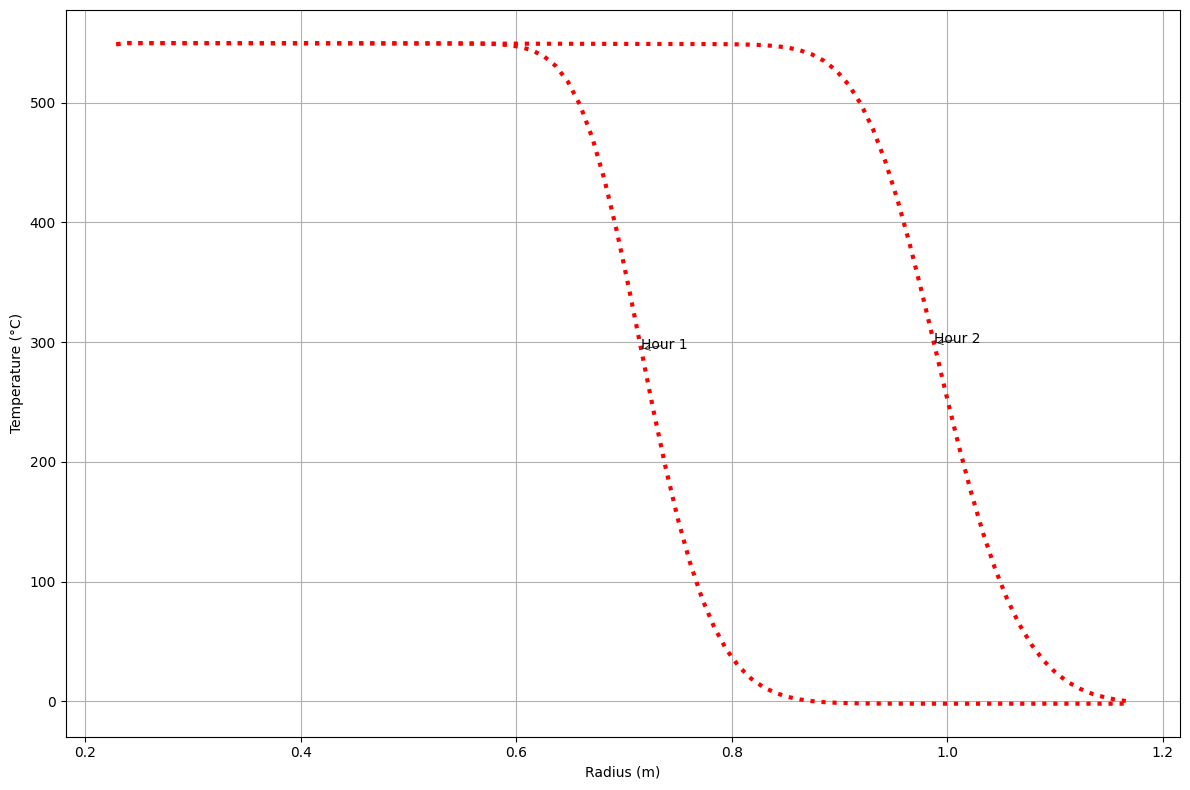

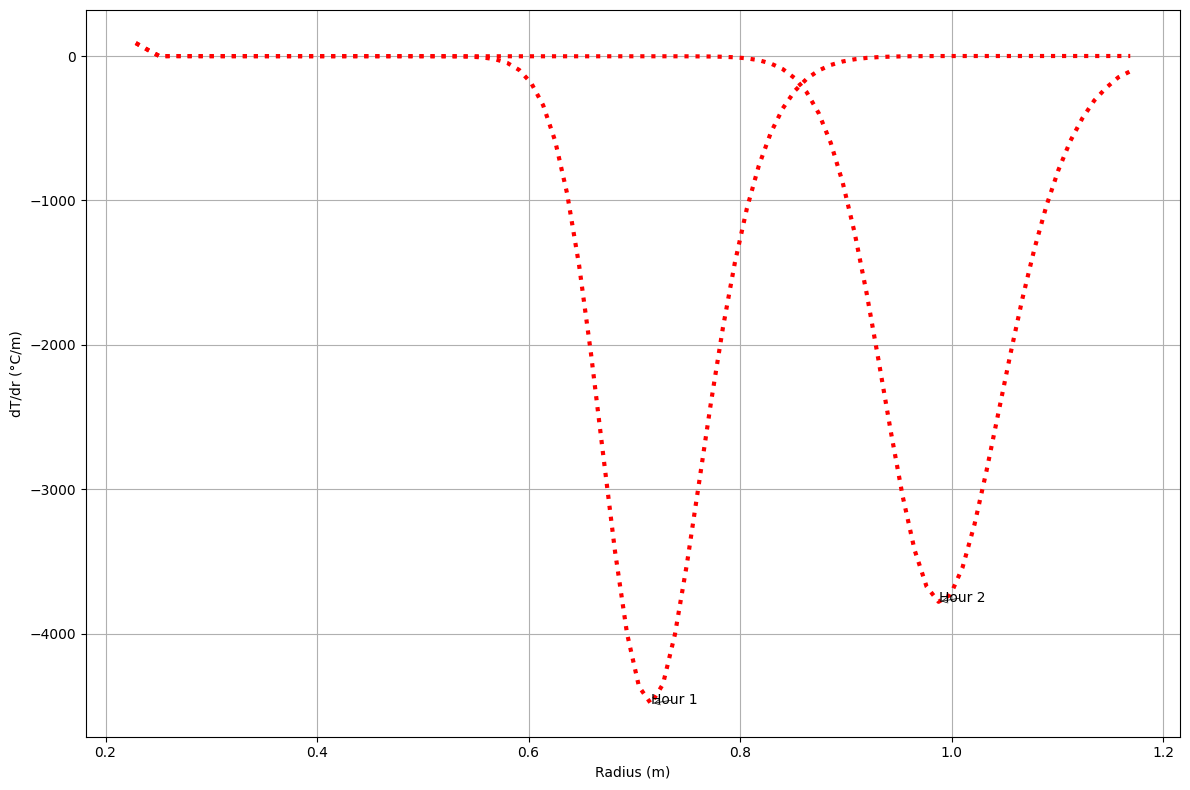

C:\Users\johns\AppData\Local\Temp\ipykernel_15900\3047936162.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = list(pd.date_range(t0, t1, freq="H"))


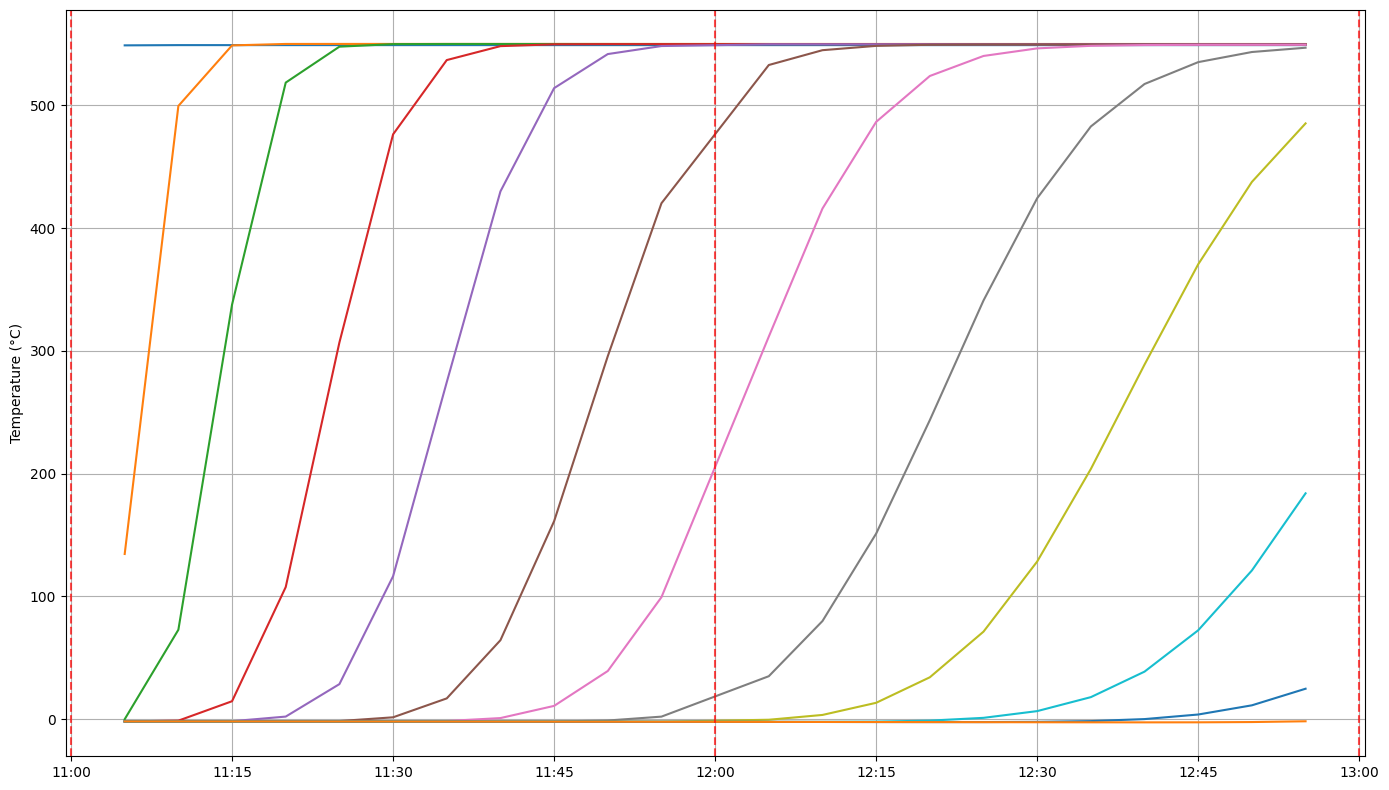

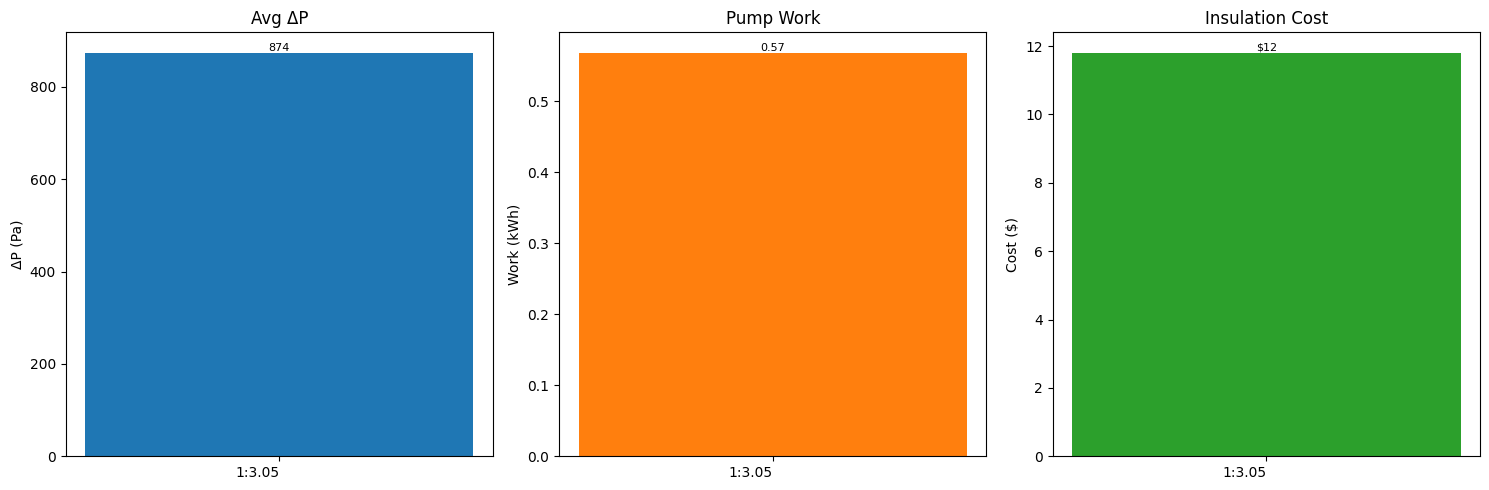

In [ ]:
# ── CONFIG ─────────────────────────────────────────────────────────────────
OUT_DIR      = r"C:\Users\johns\OneDrive\Desktop\Sandia Mic'maq\geometries sims"
PROFILES_CSV = "thermocline_profiles.csv"
HISTORY_CSV  = "thermocline_timehistory.csv"
SUMMARY_CSV  = "geometry_summary.csv"

# BASE_TIME = tea_day_spring.index[11].to_pydatetime()
BASE_TIME = datetime(2033, 3, 20, 11, 0, 0)

# ── LOAD CSVs ──────────────────────────────────────────────────────────────
profiles_path = os.path.join(OUT_DIR, PROFILES_CSV)
history_path  = os.path.join(OUT_DIR, HISTORY_CSV)
summary_path  = os.path.join(OUT_DIR, SUMMARY_CSV)

sim_df   = pd.read_csv(profiles_path)
time_df  = pd.read_csv(history_path)
summary  = pd.read_csv(summary_path)

# Drop the placeholder (time_sec == 0) rows
time_df = time_df[time_df["time_sec"] > 0].copy()

time_df["time_dt"] = time_df["time_sec"].apply(lambda s: BASE_TIME + timedelta(seconds=s))

# ── 2) FIGURE 1: Temperature vs. Radius ────────────────────────────────────
plt.figure(figsize=(12,8))
plt.xlabel("Radius (m)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
used = set()
for phase in sorted(sim_df["Phase"].unique()):
    dfp = sim_df[sim_df["Phase"] == phase]
    color = dfp["Line_Color"].iloc[0]
    rvals = dfp["Radius_m"]; Tvals = dfp["Temperature_C"]
    plt.plot(rvals, Tvals, ":", lw=3, color=color)
    grad = np.abs(np.gradient(Tvals, rvals))
    idx = np.argmax(grad)
    x,y = rvals.values[idx], Tvals.values[idx]
    dx,dy = 0.02,1.0
    while (round(x,3),round(y,3)) in used:
        x+=dx; y+=dy
    used.add((round(x,3),round(y,3)))
    plt.annotate(f"Hour {int(phase)+1}", xy=(rvals.values[idx],Tvals.values[idx]),
                 xytext=(x,y), textcoords="data", fontsize=10, ha="left",
                 arrowprops=dict(arrowstyle="->", lw=0.5))
plt.tight_layout(); plt.show()

# ── 3) FIGURE 2: Temperature Slope vs. Radius ───────────────────────────────
plt.figure(figsize=(12,8))
plt.xlabel("Radius (m)")
plt.ylabel("dT/dr (°C/m)")
plt.grid(True)
used = set()
for phase in sorted(sim_df["Phase"].unique()):
    dfp = sim_df[sim_df["Phase"] == phase]
    color = dfp["Line_Color"].iloc[0]
    rvals = dfp["Radius_m"]; Tvals = dfp["Temperature_C"]
    slope = np.gradient(Tvals, rvals)
    plt.plot(rvals, slope, ":", lw=3, color=color)
    idx = np.argmax(np.abs(slope))
    x,y = rvals.values[idx], slope[idx]
    dx,dy = 0.02,1.0
    while (round(x,3),round(y,3)) in used:
        x+=dx; y+=dy
    used.add((round(x,3),round(y,3)))
    plt.annotate(f"Hour {int(phase)+1}", xy=(rvals.values[idx],slope[idx]),
                 xytext=(x,y), textcoords="data", fontsize=10, ha="left",
                 arrowprops=dict(arrowstyle="->", lw=0.5))
plt.tight_layout(); plt.show()

# ── 4) FIGURE 3: Temperature vs. Time with Hourly Color‑Coded Lines ────────
plt.figure(figsize=(14,8))
plt.ylabel("Temperature (°C)")
plt.grid(True)
ax = plt.gca()
ax.xaxis_date(); ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# plot each node
Ts_cols = [c for c in time_df.columns if c.startswith("Ts_r")]
for col in Ts_cols:
    radius = col.split("_")[1]
    trace = time_df[col] - 273.15
    valid = (trace > -50) & np.isfinite(trace)
    ax.plot(time_df["time_dt"][valid], trace[valid], label=radius)
# vertical hour lines
t0 = BASE_TIME.replace(minute=0,second=0)
t1 = time_df["time_dt"].max().replace(minute=0,second=0)+timedelta(hours=1)
hours = list(pd.date_range(t0, t1, freq="H"))
for t in hours:
    secs = (t - BASE_TIME).total_seconds()
    idx = np.searchsorted(phase_change_times, secs, side="right")-1
    idx = max(min(idx, len(simHist)-1),0)
    Mdot = simHist[idx][0]
    color = 'r' if Mdot>0 else 'g' if Mdot==0 else 'b'
    phase = 'Charge' if Mdot>0 else 'Hold' if Mdot==0 else 'Discharge'
    handles, labels = ax.get_legend_handles_labels()
    ax.axvline(t, color=color, linestyle="--", alpha=0.7,
               label=phase if phase not in labels else "")
# plt.legend(title="Node / Phase", loc="upper right")
plt.tight_layout(); plt.show()

# ── 5) FIGURE 4: ΔP, Pump Work & Insulation Cost (1 × 3 layout) ────────────
df_sum   = summary  # you already did summary = pd.read_csv(summary_path)
ratios   = df_sum["Ratio"].values
dp_vals  = df_sum["AvgDeltaP_Pa"].values
pump_vals= df_sum["Pump_kWh"].values
ins_m    = df_sum["Insulation_m"].values

# Set your insulation unit cost
unit_cost = 58.5   # $ per m³ of super‑wool

# Use the same df_sum, ratios, dp_vals, pump_vals, ins_m, unit_cost, diameter, hole_radius as before
outer_area  = np.pi*(diameter/2)**2 - np.pi*hole_radius**2
ins_costs   = ins_m * outer_area * unit_cost
x           = np.arange(len(ratios))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# ΔP (subplot 1)
axs[0].bar(x, dp_vals, color='C0')
axs[0].set_title("Avg ΔP")
axs[0].set_ylabel("ΔP (Pa)")
for xi, h in zip(x, dp_vals):
    axs[0].text(xi, h, f"{h:.0f}", ha="center", va="bottom", fontsize=8)

# Pump Work (subplot 2)
axs[1].bar(x, pump_vals, color='C1')
axs[1].set_title("Pump Work")
axs[1].set_ylabel("Work (kWh)")
for xi, h in zip(x, pump_vals):
    axs[1].text(xi, h, f"{h:.2f}", ha="center", va="bottom", fontsize=8)

# Insulation Cost (subplot 3)
axs[2].bar(x, ins_costs, color='C2')
axs[2].set_title("Insulation Cost")
axs[2].set_ylabel("Cost ($)")
for xi, h in zip(x, ins_costs):
    axs[2].text(xi, h, f"${h:.0f}", ha="center", va="bottom", fontsize=8)

# Common X axis
for ax in axs:
    ax.set_xticks(x)
    ax.set_xticklabels(ratios, rotation=0, ha="right")

plt.tight_layout()
plt.show()
